## Что входит в работу


- Загрузка данных и разведочный анализ.
- Предположить оптимальное количество кластеров.
- Построить модель кластеризации DBSCAN.
- Определить оптимальное количество и структуру кластеров.
- Интерпретировать полученные результаты.

# Цель задачи

Имеется некоторый набор данных `gt_2.csv` о производительности и других параметрах ветряных электростанций:
* AT — температура окружающей среды.
* PT — давление окружающей среды.
* AH — влажность окружающей среды. 
* AFDP — перепад давления на воздушном фильтре. 
* GTEP — давление на выходе из газовой турбины. 
* TIT — температура на входе в турбину.
* TAT — температура на выходе из турбины. 
* TEY — энергоотдача турбины.
* CDP — давление нагнетания компрессора.
* CO — выбросы угарного газа. 
* NOX — выбросы оксидов азота.

Необходимо решить задачу кластеризации электростанций для дальнейшего совместного управления схожими электростанциями.

In [26]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN

Загрузим датасет и выполним разведочный анализ данных. Сделаем выводы о найденных закономерностях, особенностях и других свойствах данных, которые обнаружим.

In [3]:
df = pd.read_csv('gt_2.csv')
df.head()

,AT,AP,AH,AFDP,GTEP,TIT,TAT,TEY,CDP,CO,NOX
0,1.95320,1020.1,84.985,2.5304,20.116,1048.7,544.92,116.27,10.799,7.4491,113.250
1,1.21910,1020.1,87.523,2.3937,18.584,1045.5,548.50,109.18,10.347,6.4684,112.020
2,0.94915,1022.2,78.335,2.7789,22.264,1068.8,549.95,125.88,11.256,3.6335,88.147
3,1.00750,1021.7,76.942,2.8170,23.358,1075.2,549.63,132.21,11.702,3.1972,87.078
4,1.28580,1021.6,76.732,2.8377,23.483,1076.2,549.68,133.58,11.737,2.3833,82.515


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7384 entries, 0 to 7383
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AT      7384 non-null   float64
 1   AP      7384 non-null   float64
 2   AH      7384 non-null   float64
 3   AFDP    7384 non-null   float64
 4   GTEP    7384 non-null   float64
 5   TIT     7384 non-null   float64
 6   TAT     7384 non-null   float64
 7   TEY     7384 non-null   float64
 8   CDP     7384 non-null   float64
 9   CO      7384 non-null   float64
 10  NOX     7384 non-null   float64
dtypes: float64(11)
memory usage: 634.7 KB


In [5]:
print('Количество пропусков по признакам:')
df.isna().sum().sort_values(ascending=False)

Количество пропусков по признакам:


AT      0
AP      0
AH      0
AFDP    0
GTEP    0
TIT     0
TAT     0
TEY     0
CDP     0
CO      0
NOX     0
dtype: int64

In [7]:
print('Кол-во дубликатов:', df.duplicated().sum())

Кол-во дубликатов: 0


In [8]:
print('Описательные статистики:')
df.describe()

Описательные статистики:


,AT,AP,AH,AFDP,GTEP,TIT,TAT,TEY,CDP,CO,NOX
count,7384.000000,7384.00000,7384.000000,7384.000000,7384.000000,7384.000000,7384.000000,7384.000000,7384.000000,7384.000000,7384.000000
mean,17.225259,1014.50911,68.647464,3.598909,26.130149,1078.974689,546.642484,133.993380,12.097025,3.129986,59.890509
std,8.095783,6.89543,13.541116,0.610226,4.473737,19.762449,5.489066,16.179208,1.136601,2.234962,11.132464
min,-6.234800,989.40000,24.085000,2.368800,17.698000,1016.000000,516.040000,100.020000,9.870800,0.212800,25.905000
25%,11.073250,1009.67500,59.447250,3.117300,23.147000,1070.500000,544.747500,126.255000,11.465750,1.808175,52.399000
50%,17.456500,1014.00000,70.952000,3.538500,25.331000,1080.300000,549.720000,131.600000,11.933000,2.533400,56.838500
75%,23.684750,1018.30000,79.653750,4.194825,30.018250,1099.900000,550.030000,147.160000,13.148000,3.702550,65.093250
max,37.103000,1036.60000,96.666000,5.239500,40.716000,1100.400000,550.590000,179.500000,15.159000,41.097000,119.680000


In [10]:
# создадим словарь пояснений параметров

dict_param = {
            'AT': 'температура окружающей среды',
            'AP':'давление окружающей среды',
            'AH': 'влажность окружающей среды',
            'AFDP': 'перепад давления на воздушном фильтре', 
            'GTEP': 'давление на выходе из газовой турбины', 
            'TIT': 'температура на входе в турбину',
            'TAT': 'температура на выходе из турбины',
            'TEY': 'энергоотдача турбины',
            'CDP': 'давление нагнетания компрессора',
            'CO': 'выбросы угарного газа',
            'NOX': 'выбросы оксидов азота'
}

Гистограмма для температура окружающей среды


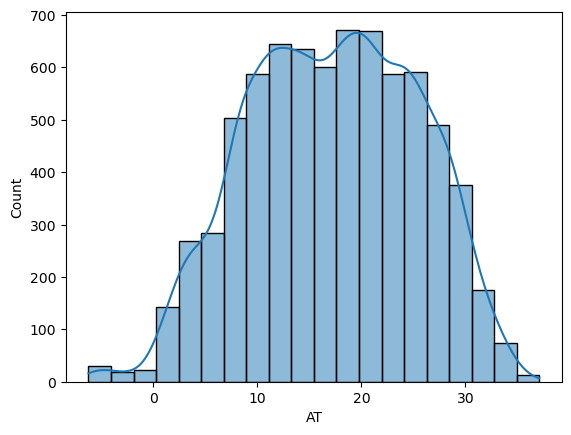

Гистограмма для давление окружающей среды


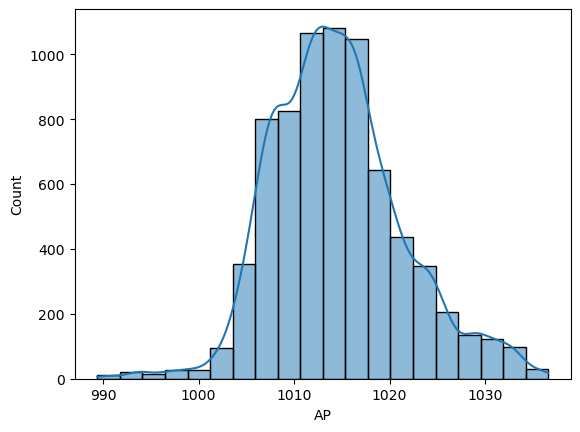

Гистограмма для влажность окружающей среды


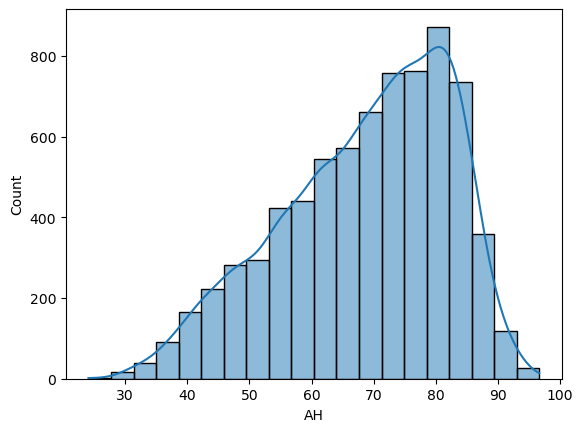

Гистограмма для перепад давления на воздушном фильтре


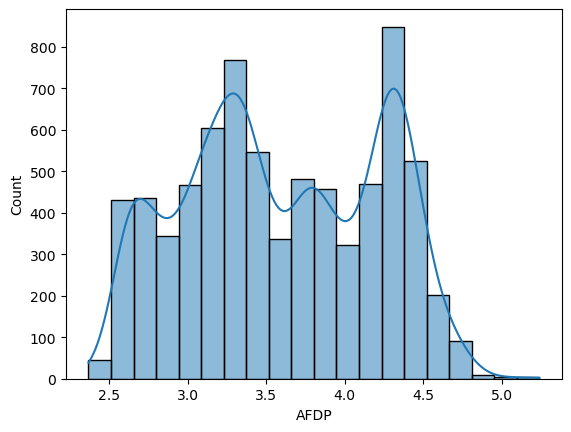

Гистограмма для давление на выходе из газовой турбины


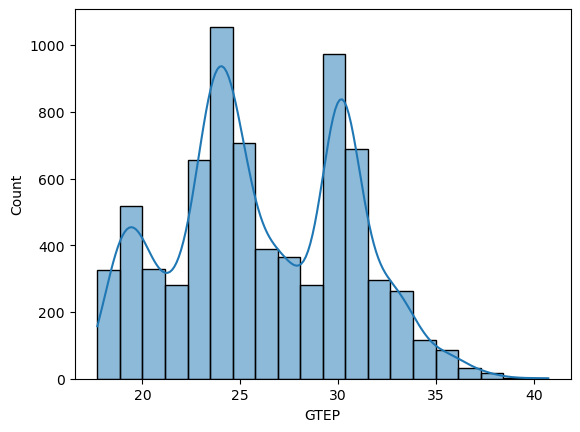

Гистограмма для температура на входе в турбину


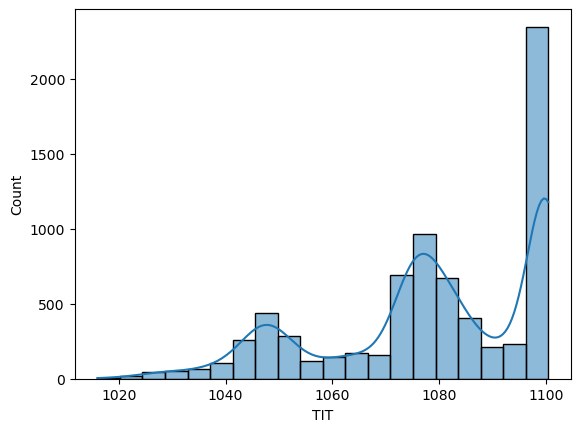

Гистограмма для температура на выходе из турбины


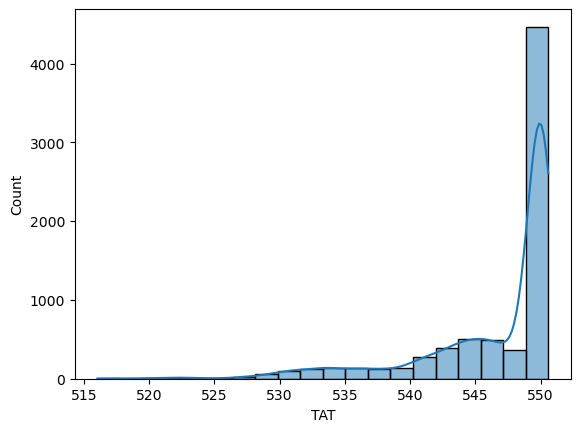

Гистограмма для энергоотдача турбины


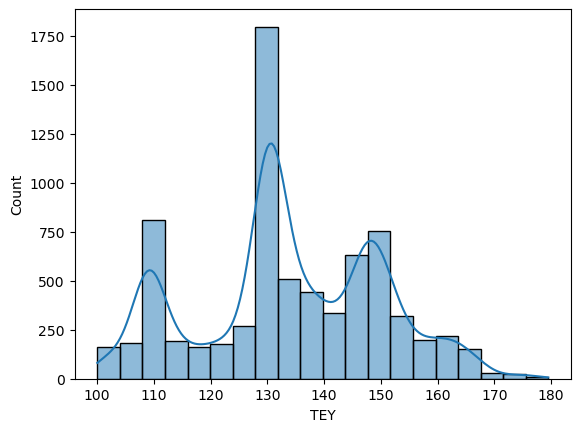

Гистограмма для давление нагнетания компрессора


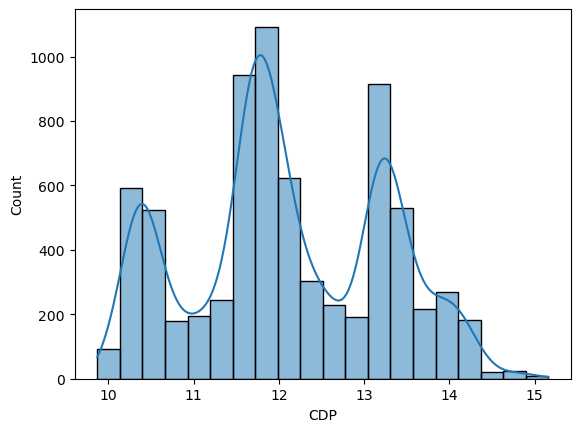

Гистограмма для выбросы угарного газа


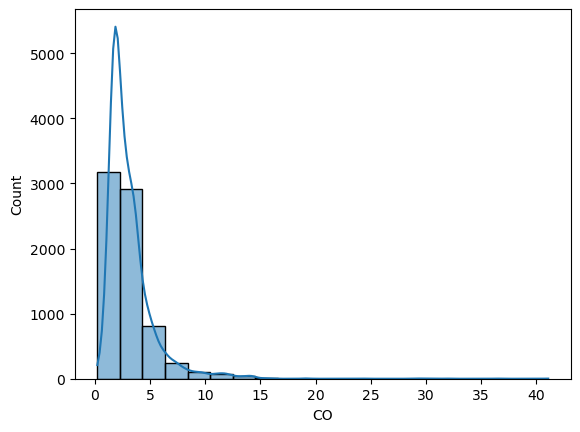

Гистограмма для выбросы оксидов азота


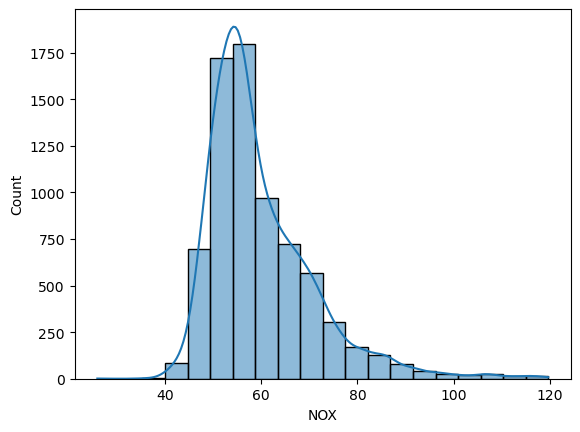

In [11]:
# Построим индивидуальные гистограммы для признаков

for key in dict_param:
  print(f'Гистограмма для {dict_param[key]}')
  sns.histplot(df[key], bins=20, kde=True)
  plt.show()

Диаграмма рассеяния энергоотдачи турбины (TEY) и температура на выходе из турбины (TAT)


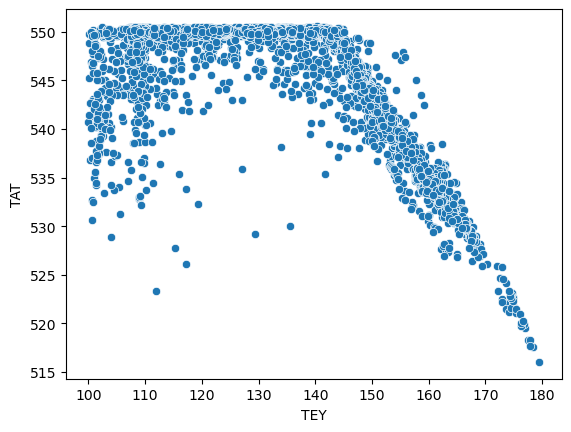

Диаграмма рассеяния энергоотдачи турбины (TEY) и давление на выходе из газовой турбины (GTEP)


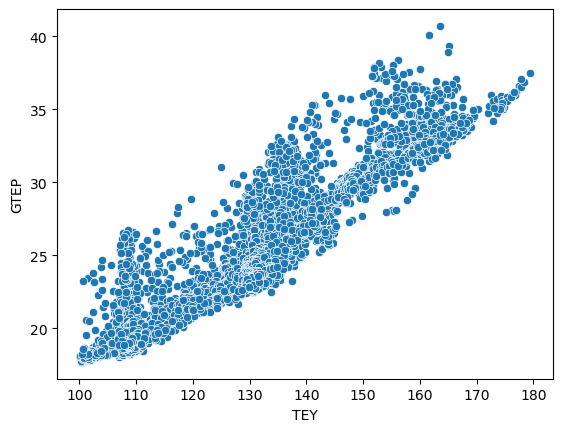

Диаграмма рассеяния энергоотдачи турбины (TEY) и давление нагнетания компрессора (CDP)


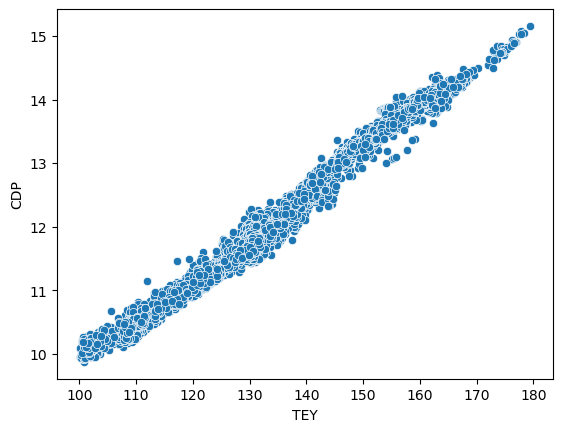

Диаграмма рассеяния энергоотдачи турбины (TEY) и выбросы угарного газа (CO)


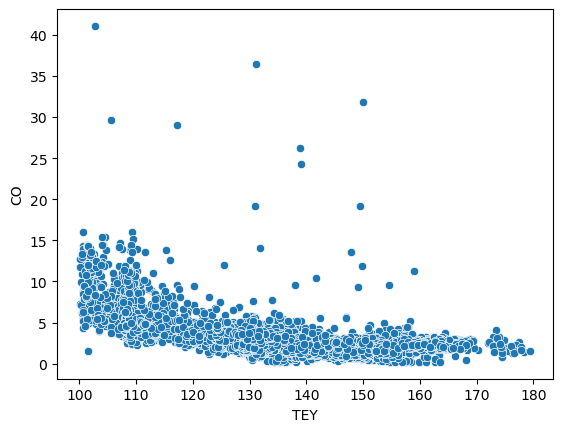

Диаграмма рассеяния энергоотдачи турбины (TEY) и выбросы оксидов азота (NOX)


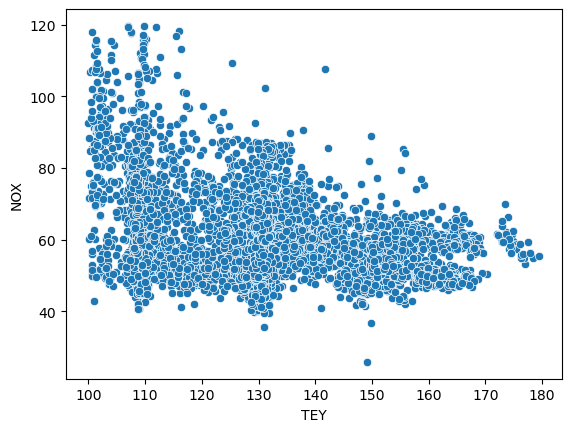

In [12]:
# Построим индивидуальные диаграммы рассеяния для некоторых признаков

dict_param1 = {
            'TAT': 'температура на выходе из турбины',
            'GTEP': 'давление на выходе из газовой турбины', 
            'CDP': 'давление нагнетания компрессора',
            'CO': 'выбросы угарного газа',
            'NOX': 'выбросы оксидов азота'
}

for key in dict_param1:
  print(f'Диаграмма рассеяния энергоотдачи турбины (TEY) и {dict_param1[key]} ({key})')
  sns.scatterplot(x=df['TEY'], y=df[key])
  plt.show()

Диаграмма рассеяния температура на выходе из турбины (TAT) и выбросы угарного газа (CO)


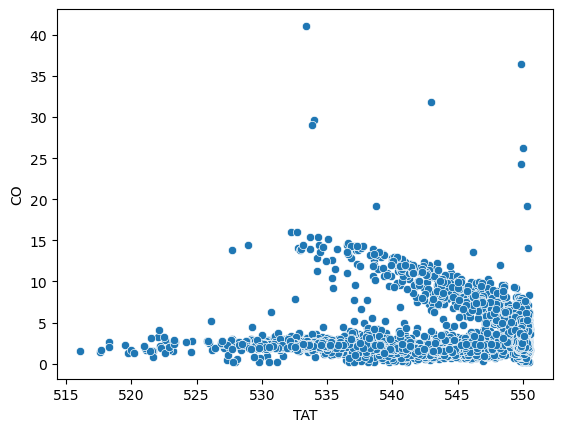

Диаграмма рассеяния температура на выходе из турбины (TAT) и выбросы оксидов азота (NOX)


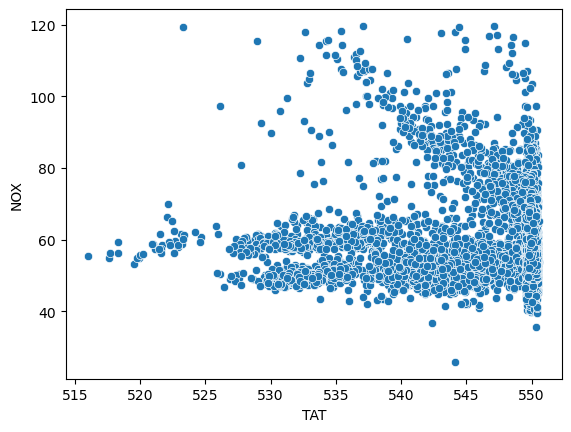

In [13]:
dict_param2 = {
            'CO': 'выбросы угарного газа',
            'NOX': 'выбросы оксидов азота'
}

for key in dict_param2:
  print(f'Диаграмма рассеяния температура на выходе из турбины (TAT) и {dict_param2[key]} ({key})')
  # sns.histplot(df[key], bins=20, kde=True)
  sns.scatterplot(x=df['TAT'], y=df[key])
  plt.show()

***По результатам анализа можно сделать следующие заключения:***

- ***Пропуски и дубликаты в данных отсутствуют.***
- ***Зависимость энергоотдачи турбины (TEY) и давления нагнетания компрессора (CDP), а также давления на выходе из газовой турбины (GTEP) линейнаая. При повышении давления растет  энергоотдача турбины.***
- ***При энергоотдачи турбины (TEY) больше 145 температура на выходе из турбины (TAT) начинает снижаться.***
- ***При энергоотдачи турбины (TEY) больше 135 CO не поднимается выше 5 и NOX выше 70 (за исключеием выбросов в данных).***
- ***В выбросах угарного газа (CO) и выбросах оксидов азота (NOX) достаточно высокие максимальные значения.***

***По результатам разведочного анализа есть предположение, что основное разделение будет по выбросам газов, энергоотдаче турбины и на условия окружающей среды. Примерно должно быть 4-5 классов.***

***По экологическим параметрам: чистые, повышенное загрязнение. По энергоэффективности: высоко производительные, среднепроизводительные, низко производительные. По условия окружающей среды: нормальные, работающие при экстримальных температурах.***

Построим модель кластеризации DBSCAN. Подберием оптимальные гиперпараметры, руководствуясь как результатами сеточного поиска, так и результатами анализа данных.

In [15]:
df1 = df.copy()

In [14]:
# Стандартизируем данные

scaler = StandardScaler()

df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
df_scaled.head()

,AT,AP,AH,AFDP,GTEP,TIT,TAT,TEY,CDP,CO,NOX
0,-1.886549,0.810866,1.206595,-1.751125,-1.344414,-1.532034,-0.313824,-1.095516,-1.142101,1.932653,4.793468
1,-1.977232,0.810866,1.394037,-1.975155,-1.686881,-1.693968,0.338426,-1.533762,-1.539805,1.493824,4.682972
2,-2.010579,1.115436,0.715465,-1.343871,-0.864246,-0.514884,0.602605,-0.501504,-0.739998,0.225305,2.538378
3,-2.003371,1.042919,0.612586,-1.281431,-0.619691,-0.191016,0.544304,-0.110234,-0.347573,0.030076,2.442346
4,-1.968993,1.028416,0.597077,-1.247506,-0.591749,-0.140412,0.553413,-0.025552,-0.316777,-0.334116,2.032436


In [16]:
# подбор гипперпараметров по сетке

eps_val = np.arange(0.5, 1.5, 0.1)
min_samples_val = range(4, 31, 2)
metric_best = -1
eps_best = 0
min_samples_best = 0

for e in eps_val:
  for s in min_samples_val:
    dbsc = DBSCAN(eps=e, min_samples=s, n_jobs=-1).fit(df_scaled)
    metric = silhouette_score(df_scaled, dbsc.labels_)
    n_clusters = len(np.unique(dbsc.labels_))
    if (metric > metric_best):
        metric_best = metric
        eps_best = e
        min_samples_best = s

print('Метрика silhouette_score:', metric_best.round(3))
print('Параметр eps_best:', eps_best)  
print('Параметр min_samples_best:', min_samples_best)  


Метрика silhouette_score: 0.382
Параметр eps_best: 1.4
Параметр min_samples_best: 18


In [17]:
model_best = DBSCAN(eps=1.4, min_samples=18, n_jobs=-1)
model_best.fit(df_scaled)

DBSCAN(eps=1.4, min_samples=18, n_jobs=-1)

In [21]:
# добавим метки кластеров в датасет и выведем количество кластеров и значений по ним

df1['labels'] = model_best.labels_
df1['labels'].value_counts()

labels
 0    7232
-1     152
Name: count, dtype: int64

***После подбора по сетке лучшая метрика получается при двух кластерах (основной кластер и выбросы), что мне кажется не совсем верно.***

In [23]:
# подберем параметры вручную исходя из анализа данных в предыдущих заданиях

model = DBSCAN(eps=0.8, min_samples=60)
model.fit(df_scaled)

df1['labels'] = model.labels_
print('Метрика silhouette_score:', silhouette_score(df_scaled, df1['labels']).round(3))

0.014

In [29]:
print('Количество кластров:', df1['labels'].nunique())
df1['labels'].value_counts()

Количество кластров: 5


labels
-1    3454
 0    2026
 2    1496
 1     263
 3     145
Name: count, dtype: int64

In [27]:
tsne = TSNE(n_components=2, perplexity=50, random_state=43, n_jobs=-1)
df_emb = tsne.fit_transform(df1)

data = pd.DataFrame(df_emb)
data.head()

,0,1
0,76.631477,16.462317
1,76.708656,16.454298
2,37.415234,38.951233
3,36.072754,41.625088
4,36.348183,41.617317


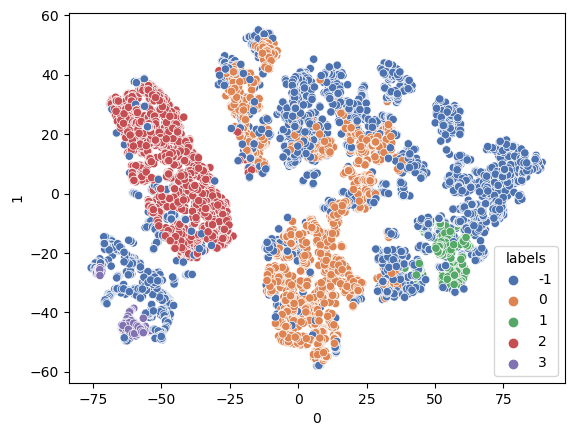

In [30]:
sns.scatterplot(x=data[0], y=data[1], hue=df1['labels'], palette="deep");

Интерпретируем результаты кластеризации: чем схожи электростанции в каждом кластере и чем аномальные электростанции отличаются от остальных. 

In [31]:
features = df1.drop('labels', axis=1).columns

df_g = df1.groupby('labels').agg({x: ['mean'] for x in features}).T

stat = np.array([[df1[feat].mean()] for feat in features]).flatten()

df_g_rel = df_g.copy()
df_g_rel['Global'] = stat

In [32]:
# теперь разделим каждый из столбцов соответствующий кластерам на Global
# чтобы узнать во сколько раз отличаются статистики каждого из кластеров от глобальных

cluster_labels = [-1, 0, 1, 2, 3]

for label in cluster_labels:
  df_g_rel[label] = 100 * df_g_rel[label] / df_g_rel['Global'] - 100

df_g_rel

,labels,-1,0,1,2,3,Global
AT,mean,-21.244812,0.704074,4.985225,51.885069,-48.124470,17.225259
AP,mean,0.105804,0.048178,-0.243987,-0.361890,0.982761,1014.509110
AH,mean,-0.677512,5.153648,13.931287,-8.352301,5.034133,68.647464
AFDP,mean,-7.288815,-2.167136,-20.814903,20.972301,25.282372,3.598909
GTEP,mean,-2.627883,-5.358909,-25.114618,15.362836,24.525520,26.130149
TIT,mean,-0.754423,0.076015,-2.734515,1.931229,1.943652,1078.974689
TAT,mean,-0.116096,0.606937,0.622039,-0.422744,-2.481594,546.642484
TEY,mean,-3.366059,-1.462305,-17.910507,10.916396,20.472652,133.993380
CDP,mean,-2.821155,-1.564788,-13.483956,9.458589,15.936287,12.097025
CO,mean,31.931277,-22.444286,44.853947,-48.610464,-26.854063,3.129986


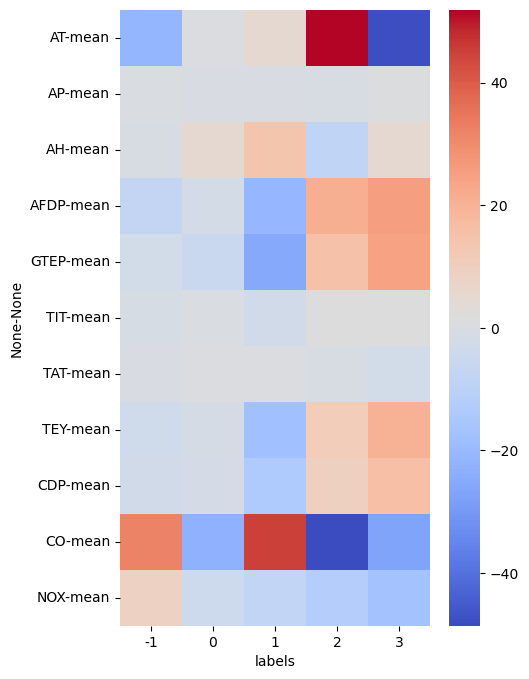

In [33]:
# подсветим max положительные и негативные отклонения от среднего
# поскольку такие отклонения дают больше всего информации о кластере

plt.figure(figsize=(5, 8))
sns.heatmap(df_g_rel[cluster_labels], cmap='coolwarm');

In [34]:
dict_param

{'AT': 'температура окружающей среды',
 'AP': 'давление окружающей среды',
 'AH': 'влажность окружающей среды',
 'AFDP': 'перепад давления на воздушном фильтре',
 'GTEP': 'давление на выходе из газовой турбины',
 'TIT': 'температура на входе в турбину',
 'TAT': 'температура на выходе из турбины',
 'TEY': 'энергоотдача турбины',
 'CDP': 'давление нагнетания компрессора',
 'CO': 'выбросы угарного газа',
 'NOX': 'выбросы оксидов азота'}

## Выводы и анализ

**Результаты кластеризации:**

- *"0" и "1" кластеры работают при средней температуре окружающей среды (AT), "-1" и "3"  кластеры работают в холодном климате, а "2" в жарком.*

- *Давление окружающей среды (AP), температура на входе в турбину (TIT), температура на выходе из турбины (TAT) одинаковы для всех кластеров.*

- *Влажность окружающей среды (AH) выше чем среднее у кластера "1" и ниже у кластера "2".*

- *Перепад давления на фильтре (AFDP) и на выходе из турбины (GTEP) у кластера "1" самый низкий, а у "2" и "3" самый высокий, у "0" и "-1" средние.*

- *Давление нагнетания компрессора (CDP) и энергоотдача турбины (TEY) у кластерров "-1" и "0" средние, у "1" ниже среднего и у "2" и "3" выше среднего.*

- *выбросы угарного газа (CO) выше среднего у кластеров "-1" и "1" и ниже у остальных. Можно предположить, что чем выше энергоотдача турбины (TEY), тем ниже выбросы угарного газа (CO).*

- *Выбросы оксидов азота (NO) ниже среднего у "2" и "3" кластеров, немного выше среднего у "-1" и средние у "0" и "1".*

*У "0" кластера все показатели близки к средним (кроме низкого СО), в то время как у остальных классов большенство показателей далеки от среднего и поэтому модель не может отнести их не к одному из классов.*

*"-1" кластер имеет также показатели близкие к средним, работает при низких температурах окружающей среды, выбросы СО и NOX чуть выше чем средние показатели.*

*"1" кластер имеет пониженное значение энергоотдачи турбины (TEY) и при этом имеет повышеные выбросы угарного газа (СО).*

*"2" и "3" кластеры имеют повышенное значение энергоотдачи турбины (TEY) и при этом более экологичнее остальных. "2" кластер работает при повышенной температуре окружаюшей среды, а "3" напротив при низких температурах, т. е. "2" и "3" кластеры работают при экстремальных температурах окружающей среды.*
